## Bibsonomy Dump Data Analysis

##### Imports & Requirements

In [21]:
#!pip install mysql-connector-python
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
def plot_frequencies(df_frequency_count, frequency_column, xlabel,ylabel,xlog= True, ylog=True):
    plt.figure(figsize=(5,5))
    plt.plot(df_frequency_count[frequency_column], df_frequency_count['count'])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlog: plt.xscale('log')
    if ylog:plt.yscale('log')
    plt.grid()
    plt.show()

#### Connect to MySQL

In [23]:
#Connect to MySQL database
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    database="mydatabase",
    password="12345678"
)
print(mydb)

In [24]:
bibtex_query = "Select * from bibtex;"
bibtex_df = pd.read_sql(bibtex_query,mydb)
tas_query = "select * from tas;"
tas_df = pd.read_sql(tas_query,mydb)
bookmark_query = "select * from bookmark;"
bookmark_df = pd.read_sql(bookmark_query,mydb)
mydb.close() #close the connection

### Tag Assignments

In [25]:
print("Tag assignments",tas_df["tag"].count())
print("Unique Tags", tas_df.nunique())

Tag assignments 4972835
Unique Tags user              15905
tag              393208
content_id      1490992
content_type          2
date             708382
dtype: int64


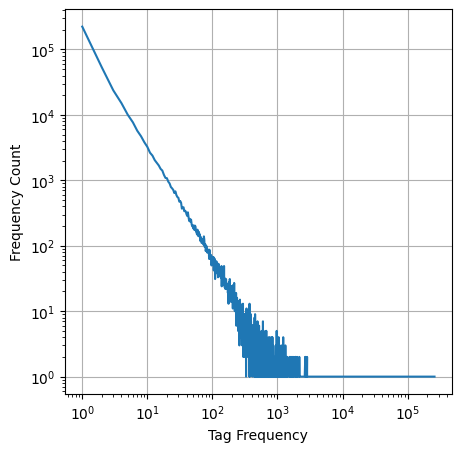

In [46]:
#Global Tag frequency
tag_frequency: pd.DataFrame = tas_df.groupby(["tag"]).size().reset_index()
tag_frequency.columns = ['tag', 'frequency']
tag_frequency_count: pd.DataFrame =tag_frequency.groupby(["frequency"]).size().reset_index()
tag_frequency_count.columns = ['tag_frequency', 'count']
plot_frequencies(tag_frequency_count,"tag_frequency","Tag Frequency","Frequency Count")

In [47]:
min_user_tas_df = remove_users_with_min_entries(tas_df,2)
print("Tag assignments",min_user_tas_df["tag"].count())
print("Unique Tags:\n", min_user_tas_df.nunique())

Tag assignments 4657419
Unique Tags:
 user               9506
tag              358055
content_id      1383031
content_type          2
date             702002
dtype: int64


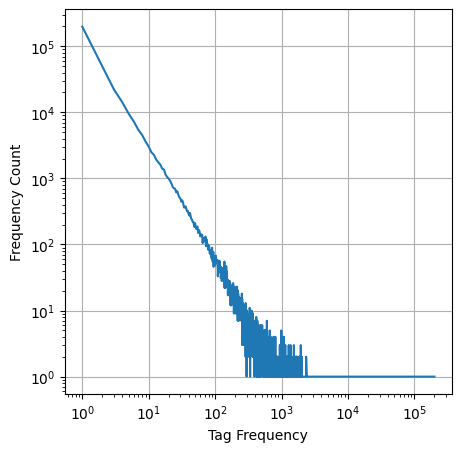

In [48]:
#Global Tag frequency with filtered Users
tag_frequency: pd.DataFrame = min_user_tas_df.groupby(["tag"]).size().reset_index()
tag_frequency.columns = ['tag', 'frequency']
tag_frequency_count: pd.DataFrame =tag_frequency.groupby(["frequency"]).size().reset_index()
tag_frequency_count.columns = ['tag_frequency', 'count']
plot_frequencies(tag_frequency_count,"tag_frequency","Tag Frequency","Frequency Count")

In [49]:
# Interactions per User
interactions_df = min_user_tas_df.groupby(["user","date"]).agg({"tag":lambda x: list(x), "content_id":"first","content_type":"first"}).reset_index()
interactions_df["tag_count"] = interactions_df["tag"].str.len()

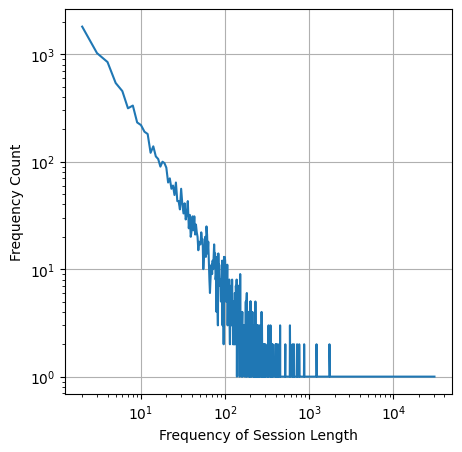

In [50]:
interaction_frequency = interactions_df.groupby(["user"]).size().reset_index()
interaction_frequency.columns = ['user', 'count']
interaction_frequency_count: pd.DataFrame =interaction_frequency.groupby(["count"]).size().reset_index()
interaction_frequency_count.columns = ['interaction_frequency', 'count']
plot_frequencies(interaction_frequency_count,"interaction_frequency","Frequency of Session Length","Frequency Count")

In [51]:
interactions_df.groupby(["user"]).size().reset_index().quantile([0.25,0.5,0.75,0.95,0.99])

,user,0
0.25,4161.75,3.00
0.50,826602.50,7.00
0.75,2655542.75,23.00
0.95,3266861.00,208.75
0.99,3399338.10,1332.90


In [52]:
interactions_df[['user', 'date', 'content_id', 'content_type', 'tag_count']].nunique()

user              9506
date            702002
content_id      705102
content_type         2
tag_count          787
dtype: int64

In [53]:
bibtex_df.nunique()

content_id        855392
journal            58652
volume             12527
chapter             1526
edition             7737
month               4783
day                  360
booktitle          78540
howPublished       10997
institution         8102
organization        2599
publisher          45187
address            20486
school              3782
series             31039
bibtexKey         734759
url               459868
type                2259
description        62294
annote              4651
note               43929
pages             144580
bKey                1996
number             22961
crossref            7376
misc              442543
bibtexAbstract    217009
simhash0          799244
simhash1          755597
simhash2          802367
entrytype             83
title             750329
author            584799
editor             66173
year                3919
dtype: int64

In [54]:
hashed_content = pd.merge(tas_df,bibtex_df, how="left", on="content_id")

hashed_content = hashed_content[hashed_content["content_type"]==2]
#hashed_content = pd.merge(hashed_content,bookmark_df[["content_id","url_hash","description"]], how="left",on="content_id")

In [55]:
hashed_content

,user,tag,content_id,content_type,date,journal,volume,chapter,edition,month,...,misc,bibtexAbstract,simhash0,simhash1,simhash2,entrytype,title,author,editor,year
937,1,semigroup,687909,2,2005-12-16 16:01:51,None,None,None,None,None,...,None,None,97c60c06d5901c2cd4e1dd321b785d83,ac48c0162b80b3afff5d099eea508961,101efca8c9368b56d680ce92329784e5,techreport,"Halbgruppen bin{""a}rer {R}elationen auf einer ...",Daniela Kriegel and Andreas Hahn and Robert J{...,None,2004
938,1,diploma,687909,2,2005-12-16 16:01:51,None,None,None,None,None,...,None,None,97c60c06d5901c2cd4e1dd321b785d83,ac48c0162b80b3afff5d099eea508961,101efca8c9368b56d680ce92329784e5,techreport,"Halbgruppen bin{""a}rer {R}elationen auf einer ...",Daniela Kriegel and Andreas Hahn and Robert J{...,None,2004
939,1,binary,687909,2,2005-12-16 16:01:51,None,None,None,None,None,...,None,None,97c60c06d5901c2cd4e1dd321b785d83,ac48c0162b80b3afff5d099eea508961,101efca8c9368b56d680ce92329784e5,techreport,"Halbgruppen bin{""a}rer {R}elationen auf einer ...",Daniela Kriegel and Andreas Hahn and Robert J{...,None,2004
940,1,relation,687909,2,2005-12-16 16:01:51,None,None,None,None,None,...,None,None,97c60c06d5901c2cd4e1dd321b785d83,ac48c0162b80b3afff5d099eea508961,101efca8c9368b56d680ce92329784e5,techreport,"Halbgruppen bin{""a}rer {R}elationen auf einer ...",Daniela Kriegel and Andreas Hahn and Robert J{...,None,2004
941,1,3elements,687909,2,2005-12-16 16:01:51,None,None,None,None,None,...,None,None,97c60c06d5901c2cd4e1dd321b785d83,ac48c0162b80b3afff5d099eea508961,101efca8c9368b56d680ce92329784e5,techreport,"Halbgruppen bin{""a}rer {R}elationen auf einer ...",Daniela Kriegel and Andreas Hahn and Robert J{...,None,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4657414,3185561,descartes,64608987,2,2022-11-17 14:30:33,Frontiers in Psychology,None,None,None,None,...,None,None,b7bab90b6e3db7ee5c35b6f71f6cb338,42cfa59b1874f9ca7dc055efd662dc5b,873b46de0dac788314295b438eff9db6,article,CortexVR: Immersive analysis and training of c...,"Krupitzer, Christian and Naber, Jens and Stauf...",None,2022
4657415,3185561,t_interdisciplinary,64608987,2,2022-11-17 14:30:33,Frontiers in Psychology,None,None,None,None,...,None,None,b7bab90b6e3db7ee5c35b6f71f6cb338,42cfa59b1874f9ca7dc055efd662dc5b,873b46de0dac788314295b438eff9db6,article,CortexVR: Immersive analysis and training of c...,"Krupitzer, Christian and Naber, Jens and Stauf...",None,2022
4657416,3185561,t_journalmagazine,64608987,2,2022-11-17 14:30:33,Frontiers in Psychology,None,None,None,None,...,None,None,b7bab90b6e3db7ee5c35b6f71f6cb338,42cfa59b1874f9ca7dc055efd662dc5b,873b46de0dac788314295b438eff9db6,article,CortexVR: Immersive analysis and training of c...,"Krupitzer, Christian and Naber, Jens and Stauf...",None,2022
4657417,3185561,myown,64608987,2,2022-11-17 14:30:33,Frontiers in Psychology,None,None,None,None,...,None,None,b7bab90b6e3db7ee5c35b6f71f6cb338,42cfa59b1874f9ca7dc055efd662dc5b,873b46de0dac788314295b438eff9db6,article,CortexVR: Immersive analysis and training of c...,"Krupitzer, Christian and Naber, Jens and Stauf...",None,2022


In [56]:
hashed_content.nunique()

user                7874
tag               245202
content_id        753467
content_type           1
date              278379
journal            49363
volume             11274
chapter             1332
edition             7265
month               3844
day                  358
booktitle          67637
howPublished        8988
institution         6433
organization        2142
publisher          40523
address            18096
school              3199
series             29476
bibtexKey         643911
url               441404
type                1803
description        61489
annote              3232
note               39128
pages             127628
bKey                1198
number             19874
crossref            6621
misc              394558
bibtexAbstract    199203
simhash0          703216
simhash1          667751
simhash2          706051
entrytype             75
title             658685
author            510857
editor             61461
year                3445
dtype: int64

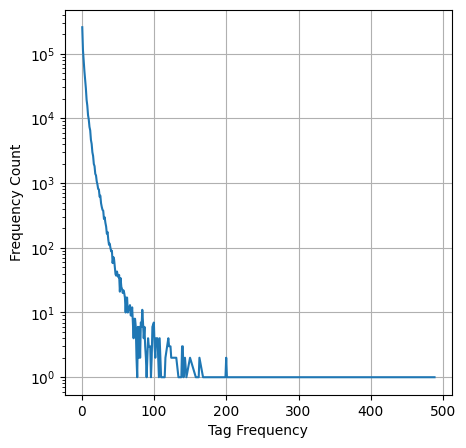

In [60]:
#Global Tag frequency with filtered Users
simhash1_counts = hashed_content.groupby(["simhash1"]).size().reset_index()
simhash1_counts.columns = ['hash', 'frequency']
simhash1_frequency_count: pd.DataFrame = simhash1_counts.groupby(["frequency"]).size().reset_index()
simhash1_frequency_count.columns = ['tag_frequency', 'count']
plot_frequencies(simhash1_frequency_count,"tag_frequency","Simhash Frequency","Frequency Count", xlog=False)

## bookmarks

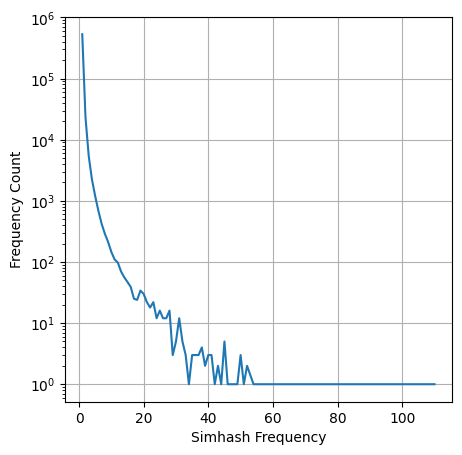

In [13]:
#Global Tag frequency with filtered Users
bookmark_df_counts = bookmark_df.groupby(["url_hash"]).size().reset_index()
bookmark_df_counts.columns = ['hash', 'frequency']
bookmark_df_counts_frequency: pd.DataFrame = bookmark_df_counts.groupby(["frequency"]).size().reset_index()
bookmark_df_counts_frequency.columns = ['tag_frequency', 'count']
plot_frequencies(bookmark_df_counts_frequency,"tag_frequency","Simhash Frequency","Frequency Count", xlog=False)

In [209]:
bookmark_df_counts[bookmark_df_counts["frequency"]>3]

,hash,frequency
18,0002f932b3c1e6e5a715f5b52de400a8,5
64,0008dcb35fceab9dc1745884de895c0e,9
77,00099d895629c88c4444f66bc04d4f4f,4
360,002a76e500095e7a768e9d6fce206768,5
495,003a38f609e076a40db18ef825ba8e0a,7
...,...,...
565566,ffde32f591989c0b516868dfb78cec9c,4
565595,ffe21f499704a8215d12f6879b2db6f6,4
565754,fff45254893f0f3e0528e1bc1e2b9c23,5
565767,fff546055fbfecdee79bd0281e80d5ca,5


## Merge Dataset and Use Core

In [210]:
def remove_users_with_min_entries(df, min_entries):
    nunique = df["user"].nunique()
    grouped_tags = df.groupby(['date', 'user'])
    # Group Tags
    count_tags = grouped_tags.size().reset_index(name='count')
    # Group and count user interactions
    count = count_tags.groupby("user").size().reset_index(name='count')
    # Get a list of users with less than 2 entries
    users_to_remove = count[count['count'] < min_entries]['user'].tolist()
    # Remove the entries for those users
    df = df[~df['user'].isin(users_to_remove)]
    change = nunique-df["user"].nunique()
    print("Removed ",change," users with sessions < ",min_entries)
    return df, change

In [280]:
def remove_group_with_min_entries(df, group ,min_entries):
    nunique = df[group].nunique()
    grouped_tags = df.groupby([group])
    # Group Tags
    count = grouped_tags.size().reset_index(name='count')
    items_to_remove = count[count['count'] < min_entries][group].tolist()
    df = df[~df[group].isin(items_to_remove)]
    change = nunique-df[group].nunique()
    print("Removed ",change," entries from group with frequency < ",min_entries)
    return df, change

In [281]:
def replace_tags_with_min_entries(df, group, min_entries):
    nunique = df[group].nunique()
    grouped_tags = df.groupby([group])
    # Group Tags
    count = grouped_tags.size().reset_index(name='count')
    items_to_remove = count[count['count'] < min_entries][group].tolist()
    df.loc[df[group].isin(items_to_remove),group] = "unknown_"+group
    change = nunique-df[group].nunique()
    print("Replaced ",change," tags with unknown")
    return df, change

In [282]:
def drop_duplicate_tags(df):
    temp_len = (len(df))
    df =df.drop_duplicates()
    change = temp_len -len(df)
    print("Dropped ", change, " duplicates.")
    return df, change

In [283]:
def publication_core_x(df,x):
    print(df.nunique(),"\n")
    changes = 1
    while changes!= 0:
        print("\n----- Apply filters ------")
        df, changes = replace_tags_with_min_entries(df, "tag", x)
        df, change = drop_duplicate_tags(df)
        changes += change
        df, change = remove_group_with_min_entries(df, "simhash1",x)
        changes += change
        df, change = remove_users_with_min_entries(df, x)
        changes += change
    print("\n",df.nunique(),"\n")
    return df

In [241]:
hashed_content = pd.merge(tas_df,bibtex_df, how="left", on="content_id")
hashed_content1 = hashed_content[hashed_content["content_type"]==2]
hashed_content1 = hashed_content1.loc[:,["user","tag","content_type","content_id","date","simhash1"]].copy()

In [242]:
publications_core_5 = publication_core_x(hashed_content1,5)
print(len(publications_core_5), "Interactions")

user             11952
tag             277935
content_type         1
content_id      855392
date            282448
simhash1        755597
dtype: int64 

----- Apply filters ------

Replaced  226512  tags with unknown
Dropped  159287  duplicates.
Removed  571039  entries from group with frequency <  5
Removed  4861  users with sessions <  5
----- Apply filters ------

Replaced  13818  tags with unknown
Dropped  23287  duplicates.
Removed  0  entries from group with frequency <  5
Removed  0  users with sessions <  5
----- Apply filters ------

Replaced  0  tags with unknown
Dropped  0  duplicates.
Removed  0  entries from group with frequency <  5
Removed  0  users with sessions <  5
user              2349
tag              29828
content_type         1
content_id      198502
date            118779
simhash1        149258
dtype: int64 



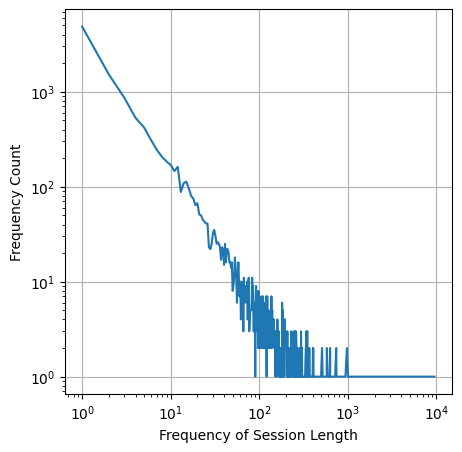

In [244]:
# Interactions per User
interactions_df = hashed_content1.groupby(["user", "date"]).agg(
    {"tag": lambda x: list(x), "content_id": "first", "content_type": "first"}).reset_index()
interactions_df["tag_count"] = interactions_df["tag"].str.len()
interaction_frequency = interactions_df.groupby(["user"]).size().reset_index()
interaction_frequency.columns = ['user', 'count']
interaction_frequency_count: pd.DataFrame = interaction_frequency.groupby(["count"]).size().reset_index()
interaction_frequency_count.columns = ['interaction_frequency', 'count']
plot_frequencies(interaction_frequency_count, "interaction_frequency", "Frequency of Session Length", "Frequency Count")

In [245]:
interactions_df.groupby(["user"]).size().reset_index().describe()

,user,0
count,1.195200e+04,11952.000000
mean,1.487675e+06,23.670515
std,1.236544e+06,156.322594
min,0.000000e+00,1.000000
25%,2.706198e+05,1.000000
50%,1.366874e+06,2.000000
75%,2.827243e+06,9.000000
max,3.467817e+06,9505.000000


In [246]:
bookmark_df

,content_id,url_hash,url,description,extended,date
0,7,748857bb01f0731b58bbabd13a88bfad,http://www.coloradoboomerangs.com/,Colorado Boomerangs,,2005-12-15 19:31:50
1,8,7edfc1f9560521e83bcf5a5768889c6c,http://jo.irisson.free.fr/bstdatabase/,LaTeX Bibliography Styles Database :: Search,,2005-12-13 08:42:37
2,11,e636edf2736cfc61897bf21039ffea1b,http://acmqueue.com/modules.php?name=Content&p...,Social Bookmarking in the Enterprise,,2005-12-07 09:08:51
3,12,2f87c060c8ada01d4500e8a27749dee8,http://www.cs.stir.ac.uk/~kjt/software/latex/s...,BibTeX Style Examples,,2005-12-06 13:57:37
4,13,bfb258bc024470f88f8d38c2c4d820ab,http://virtual.cvut.cz:8080/ksmsaWeb/browser/t...,The KSMSA Project - Ontology Browser,,2005-12-02 09:46:10
...,...,...,...,...,...,...
635599,64607159,99a8cee553868a205695d81d093a6999,https://www.youtube.com/watch?v=qmJD2S3oy4M,Under 1200 Rated? Watch This. - YouTube,,2022-11-16 19:26:54
635600,64607161,91e1e6fa2da67be45451834929aea801,https://www.youtube.com/watch?v=CepTyY9NHGM,Under 800 Rated? Watch This. - YouTube,,2022-11-08 20:16:00
635601,64607162,881f03017e96a4115f86b9248ccb73e2,https://www.youtube.com/watch?v=Qp_rB1fN3Gs,5 Pawn Endgames You MUST Know - YouTube,,2022-11-03 15:38:43
635602,64607164,b10ea30930b4d2cc71932d5c873aa42f,https://www.youtube.com/watch?v=AN4gqEqIXm0,The BEST Way To Calculate in Chess - YouTube,,2022-11-03 15:38:06


In [275]:
def replace_tags_not_in_main_df(df, main_df):
    nunique = df["tag"].nunique()
    df.loc[~df["tag"].isin(main_df["tag"].unique()),"tag"] = "unknown_tag"
    change = nunique-df["tag"].nunique()
    print("Replaced ",change," tags with unknown")
    return df, change

In [286]:
bookmark_core = hashed_content[hashed_content["content_type"]==1].copy()
bookmark_core, change = replace_tags_not_in_main_df(bookmark_core, publications_core_5)
bookmark_core, change = drop_duplicate_tags(bookmark_core)
bookmark_core = pd.merge(bookmark_core,bookmark_df[["content_id","url_hash","description"]], how="left",on="content_id")

Replaced  146705  tags with unknown
Dropped  506554  duplicates.


In [287]:
bookmark_core

,user,tag,content_id,content_type,date,journal,volume,chapter,edition,month,...,simhash0,simhash1,simhash2,entrytype,title,author,editor,year,url_hash,description_y
0,0,unknown_tag,7,1,2005-12-15 19:31:50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,748857bb01f0731b58bbabd13a88bfad,Colorado Boomerangs
1,0,shop,7,1,2005-12-15 19:31:50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,748857bb01f0731b58bbabd13a88bfad,Colorado Boomerangs
2,0,bibtex,8,1,2005-12-13 08:42:37,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7edfc1f9560521e83bcf5a5768889c6c,LaTeX Bibliography Styles Database :: Search
3,0,latex,8,1,2005-12-13 08:42:37,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7edfc1f9560521e83bcf5a5768889c6c,LaTeX Bibliography Styles Database :: Search
4,0,style,8,1,2005-12-13 08:42:37,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7edfc1f9560521e83bcf5a5768889c6c,LaTeX Bibliography Styles Database :: Search
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632579,3011351,videos,64607164,1,2022-11-03 15:38:06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b10ea30930b4d2cc71932d5c873aa42f,The BEST Way To Calculate in Chess - YouTube
1632580,3011351,unknown_tag,64607165,1,2022-11-03 15:37:12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,099155f3b06686c0e928cb8c8f5b2f2a,5 Common Mistakes BEGINNERS Make in Chess - Yo...
1632581,3011351,howto,64607165,1,2022-11-03 15:37:12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,099155f3b06686c0e928cb8c8f5b2f2a,5 Common Mistakes BEGINNERS Make in Chess - Yo...
1632582,3011351,learn,64607165,1,2022-11-03 15:37:12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,099155f3b06686c0e928cb8c8f5b2f2a,5 Common Mistakes BEGINNERS Make in Chess - Yo...


In [288]:
bookmark_core["url_hash"].nunique()

565840

In [289]:
bookmark_core, change = remove_group_with_min_entries(bookmark_core, "url_hash" ,5)

Removed  473996  entries from group with frequency <  5


In [290]:
bookmark_core["url_hash"].nunique()

91844

In [291]:
publications_core_5.append(bookmark_core)

,user,tag,content_type,content_id,date,simhash1,journal,volume,chapter,edition,...,bibtexAbstract,simhash0,simhash2,entrytype,title,author,editor,year,url_hash,description_y
941,1,semigroup,2,687909,2005-12-16 16:01:51,ac48c0162b80b3afff5d099eea508961,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942,1,diploma,2,687909,2005-12-16 16:01:51,ac48c0162b80b3afff5d099eea508961,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
943,1,binary,2,687909,2005-12-16 16:01:51,ac48c0162b80b3afff5d099eea508961,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
944,1,relation,2,687909,2005-12-16 16:01:51,ac48c0162b80b3afff5d099eea508961,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
945,1,unknown_tag,2,687909,2005-12-16 16:01:51,ac48c0162b80b3afff5d099eea508961,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632547,1602,datenanalyse,1,64577789,2022-12-31 21:51:40,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ad51ea03925de7cb4d8fe1e8a0f94ff,8.16 Making a Circular Plot | R Graphics Cookb...
1632548,1602,grafik,1,64577789,2022-12-31 21:51:40,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ad51ea03925de7cb4d8fe1e8a0f94ff,8.16 Making a Circular Plot | R Graphics Cookb...
1632549,1602,howto,1,64577789,2022-12-31 21:51:40,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ad51ea03925de7cb4d8fe1e8a0f94ff,8.16 Making a Circular Plot | R Graphics Cookb...
1632550,1602,unknown_tag,1,64577789,2022-12-31 21:51:40,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ad51ea03925de7cb4d8fe1e8a0f94ff,8.16 Making a Circular Plot | R Graphics Cookb...


In [292]:
publications_core_5.nunique()

user              2349
tag              29828
content_type         1
content_id      198502
date            118779
simhash1        149258
dtype: int64